# Munich Bicycle Data - Cleaned

This jupyter notebook cleanes and normalizes raw data from the munich bicycle tracking stations.

## Documentation of input data

You find a detailed documentation of the input data source in the **README.md** in this folder.

This is the most relevant overview:

* The API offers metadata in json format
* The metadata contains links to csv files
* There are csv files with the counting data per day and per 15 minute intervals
* There is an extra csv file with information about the counting stations

## Analyzing the input data

### Bicycle Counting Stations

In [1]:
import glob
import pandas
import os

# increase output width to be able to read all "besonderheiten" (special cases)
pandas.options.display.max_colwidth = 300

counting_stations_csv = glob.glob("./raw/*radzaehlstellen.csv")[0]
df_counting_stations = pandas.read_csv(counting_stations_csv)
df_counting_stations

,zaehlstelle,zaehlstelle_lang,latitude,longitude,richtung_1,richtung_2,besonderheiten
0,Arnulf,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.
1,Kreuther,Bad-Kreuther-Str.,48.12194,11.62417,West,Ost,"Im April 2020 wurde die Zählschleife am Joseph-Hörwick-Weg auf den gesamten Querschnitt des Fuß- und Radweges ausgeweitet. Die Breite der Zählschleife hat sich dadurch in etwa verdoppelt. Bitte beachten Sie, dass Veränderungen in den Zahlen ab dem 1. April 2020 darauf zurückzuführen sind."
2,Olympia,Rudolf-Harbig-Weg (Olympia Park),48.16887,11.55005,Nord,Süd,NaN
3,Hirsch,Birketweg HLP (Hirschgarten),48.14438,11.51794,West,Ost,NaN
4,Margareten,Margaretenstr. (Harras),48.12032,11.53599,West,Ost,NaN
5,Erhardt,Erhardtstr. (Deutsches Museum),48.13192,11.58469,Süd,Nord,Es wird auf dem Fahrradweg als auch auf dem Fußweg gezählt.


## Daily Data

In [2]:
import os

def read_all(glob_expression):
    data_csvs = glob.glob(glob_expression)    
    dfs = []
    for data_csv in data_csvs:
        data = pandas.read_csv(data_csv)

        # Fix inconsistent column names
        if 'min.temp' in data.columns:
            data = data.rename(columns={'min.temp': 'min-temp'})
        if 'max.temp' in data.columns:
            data = data.rename(columns={'max.temp': 'max-temp'})

        data['datei'] = os.path.basename(data_csv)
        dfs.append(data)
    df_all_data = pandas.concat(dfs, ignore_index=True)
    return df_all_data
   
df_daily_data = read_all("raw/*rad*tage*.csv")
df_daily_data = df_daily_data.merge(df_counting_stations, on='zaehlstelle')
df_daily_data['besonderheiten'] = df_daily_data['besonderheiten'].fillna('')

df_daily_data.head(3)

,datum,uhrzeit_start,uhrzeit_ende,zaehlstelle,richtung_1_x,richtung_2_x,gesamt,min-temp,max-temp,niederschlag,bewoelkung,sonnenstunden,datei,zaehlstelle_lang,latitude,longitude,richtung_1_y,richtung_2_y,besonderheiten
0,2017.03.01,00:00:00,23.59,Arnulf,742,52,794,1.4,8.1,3.9,85,1.4,daten-der-raddauerzaehlstellen-muenchen-maerz-2017-c9af32b1-fc32-4099-be51-4df58a577919-rad201703tage.csv,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.
1,2017.03.02,00:00:00,23.59,Arnulf,706,72,778,3.4,10.7,0.1,58,4.2,daten-der-raddauerzaehlstellen-muenchen-maerz-2017-c9af32b1-fc32-4099-be51-4df58a577919-rad201703tage.csv,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.
2,2017.03.03,00:00:00,23.59,Arnulf,921,73,994,1.0,13.1,0.0,75,4.6,daten-der-raddauerzaehlstellen-muenchen-maerz-2017-c9af32b1-fc32-4099-be51-4df58a577919-rad201703tage.csv,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.


In [3]:
# We have the same data count on all counting stations which is fine
df_daily_data['zaehlstelle'].value_counts()

zaehlstelle
Kreuther      7669
Olympia       7669
Hirsch        7669
Arnulf        7638
Margareten    6544
Erhardt       6544
Name: count, dtype: int64

### Correct date column

In [4]:
# The date format in most columns is 2017.03.03 meaning '%Y.%m.%d', but there a couple of ones
# which don't match the format, so this throws exceptions
# df_daily_data['datum'] = pandas.to_datetime(df_daily_data['datum'], format='%Y.%m.%d')
#   ValueError: time data "01.05.2022" at position 793 doesn't match format specified
from re import match

WRONG_DATE_PATTERN = '^[0-9]{2}\.[0-9]{2}\.[0-9]{4}$'
WRONG_DATE_PATTERN_GROUPS = '^([0-9]{2})\.([0-9]{2})\.([0-9]{4})$'

def reformat_date(input_data):
    groups = match(WRONG_DATE_PATTERN_GROUPS, input_data)
    corrected_input = input_data
    if groups:
        corrected_input = groups.group(3) + "." + groups.group(2) + "." + groups.group(1)
    
    return corrected_input.replace(".", "-")

df_daily_data[df_daily_data.datum.str.contains(WRONG_DATE_PATTERN)].count()

datum               366
uhrzeit_start       366
uhrzeit_ende        366
zaehlstelle         366
richtung_1_x        366
richtung_2_x        366
gesamt              366
min-temp            366
max-temp            366
niederschlag        366
bewoelkung          366
sonnenstunden       366
datei               366
zaehlstelle_lang    366
latitude            366
longitude           366
richtung_1_y        366
richtung_2_y        366
besonderheiten      366
dtype: int64

In [5]:
df_daily_data['datum'] = df_daily_data['datum'].apply(reformat_date)

In [6]:
df_daily_data[df_daily_data.datum.str.contains(WRONG_DATE_PATTERN)].count()

datum               0
uhrzeit_start       0
uhrzeit_ende        0
zaehlstelle         0
richtung_1_x        0
richtung_2_x        0
gesamt              0
min-temp            0
max-temp            0
niederschlag        0
bewoelkung          0
sonnenstunden       0
datei               0
zaehlstelle_lang    0
latitude            0
longitude           0
richtung_1_y        0
richtung_2_y        0
besonderheiten      0
dtype: int64

In [7]:
# Now as the dates are in uniform form we can convert the strings to datetime to get a nicer plot
df_daily_data['datum'] = pandas.to_datetime(df_daily_data['datum'], format='%Y-%m-%d')


# Drop unnecessary columns
df_daily_data = df_daily_data.drop(columns=['uhrzeit_start', 'uhrzeit_ende'])

# Unify formats
df_daily_data['min-temp'] = df_daily_data['min-temp'].astype(str).str.replace(',', '.').astype(float)
df_daily_data['max-temp'] = df_daily_data['max-temp'].astype(str).str.replace(',', '.').astype(float)
df_daily_data['niederschlag'] = df_daily_data['niederschlag'].astype(str).str.replace(',', '.').astype(float)
df_daily_data['sonnenstunden'] = df_daily_data['sonnenstunden'].astype(str).str.replace(',', '.').astype(float)

# Cast types to unify entries

df_daily_data = df_daily_data.astype({
    'zaehlstelle': 'str',
    'richtung_1_x': 'int',
    'richtung_2_x': 'int',
    'gesamt': 'int',
    'min-temp': 'float',
    'max-temp': 'float',
    'niederschlag': 'float',
    'bewoelkung': 'float',
    'sonnenstunden': 'float',
    'datei': 'str',
    'zaehlstelle_lang': 'str',
    'latitude': 'float',
    'longitude': 'float',
    'richtung_1_y': 'str',
    'richtung_2_y': 'str',
    'besonderheiten': 'str'
})


columns_to_check = [col for col in df_daily_data.columns if col != 'datei']

df_daily_data = df_daily_data.drop_duplicates(columns_to_check)

<Axes: xlabel='datum'>

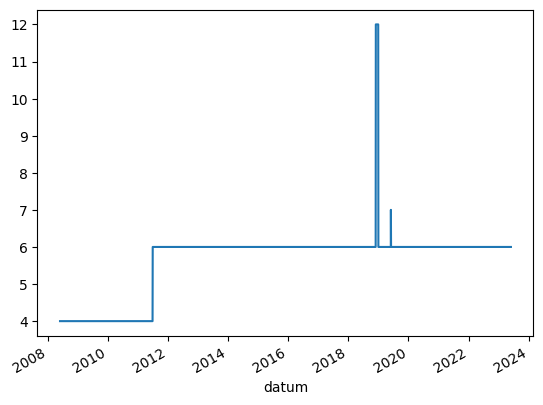

In [8]:
df_daily_data['datum'].value_counts().plot()

In [9]:
# count values per day (6 is the expected result as we have 6 stations)
df_daily_data = df_daily_data.sort_values(by='datum')
df_daily_data.set_index('datum', inplace=True)

#list(df_daily_data.columns)

In [10]:
df_daily_data.loc["2019-06-03"].head(20)


,zaehlstelle,richtung_1_x,richtung_2_x,gesamt,min-temp,max-temp,niederschlag,bewoelkung,sonnenstunden,datei,zaehlstelle_lang,latitude,longitude,richtung_1_y,richtung_2_y,besonderheiten
datum,,,,,,,,,,,,,,,,
2019-06-03,Kreuther,106,275,381,12.8,29.8,0.3,19.0,13.8,daten-der-raddauerzaehlstellen-muenchen-juni-2019-2778adcb-f051-4837-adec-34dc19343f30-rad201906tageneu.csv,Bad-Kreuther-Str.,48.12194,11.62417,West,Ost,"Im April 2020 wurde die Zählschleife am Joseph-Hörwick-Weg auf den gesamten Querschnitt des Fuß- und Radweges ausgeweitet. Die Breite der Zählschleife hat sich dadurch in etwa verdoppelt. Bitte beachten Sie, dass Veränderungen in den Zahlen ab dem 1. April 2020 darauf zurückzuführen sind."
2019-06-03,Erhardt,4222,3978,8200,12.8,29.8,0.3,19.0,13.8,daten-der-raddauerzaehlstellen-muenchen-jahreszahlen-022a11ff-4dcb-4f03-b7dd-a6c94a094587-rad_2019_tage_export_09_02_23_r.csv,Erhardtstr. (Deutsches Museum),48.13192,11.58469,Süd,Nord,Es wird auf dem Fahrradweg als auch auf dem Fußweg gezählt.
2019-06-03,Kreuther,48,99,147,12.8,29.8,0.3,19.0,13.8,daten-der-raddauerzaehlstellen-muenchen-jahreszahlen-022a11ff-4dcb-4f03-b7dd-a6c94a094587-rad_2019_tage_export_09_02_23_r.csv,Bad-Kreuther-Str.,48.12194,11.62417,West,Ost,"Im April 2020 wurde die Zählschleife am Joseph-Hörwick-Weg auf den gesamten Querschnitt des Fuß- und Radweges ausgeweitet. Die Breite der Zählschleife hat sich dadurch in etwa verdoppelt. Bitte beachten Sie, dass Veränderungen in den Zahlen ab dem 1. April 2020 darauf zurückzuführen sind."
2019-06-03,Hirsch,1344,1403,2747,12.8,29.8,0.3,19.0,13.8,daten-der-raddauerzaehlstellen-muenchen-jahreszahlen-022a11ff-4dcb-4f03-b7dd-a6c94a094587-rad_2019_tage_export_09_02_23_r.csv,Birketweg HLP (Hirschgarten),48.14438,11.51794,West,Ost,
2019-06-03,Arnulf,644,51,695,12.8,29.8,0.3,19.0,13.8,daten-der-raddauerzaehlstellen-muenchen-jahreszahlen-022a11ff-4dcb-4f03-b7dd-a6c94a094587-rad_2019_tage_export_09_02_23_r.csv,Arnulfstr. 9 - 11 Südseite,48.14205,11.55534,Ost,West,nur Stadteinwärts. Die Zählungen der Zählstelle Arnulfstraße sind seit Anfang 2021 stark von der dortigen Baustelle beeinflusst.
2019-06-03,Olympia,1680,1743,3423,12.8,29.8,0.3,19.0,13.8,daten-der-raddauerzaehlstellen-muenchen-jahreszahlen-022a11ff-4dcb-4f03-b7dd-a6c94a094587-rad_2019_tage_export_09_02_23_r.csv,Rudolf-Harbig-Weg (Olympia Park),48.16887,11.55005,Nord,Süd,
2019-06-03,Margareten,2622,2591,5213,12.8,29.8,0.3,19.0,13.8,daten-der-raddauerzaehlstellen-muenchen-jahreszahlen-022a11ff-4dcb-4f03-b7dd-a6c94a094587-rad_2019_tage_export_09_02_23_r.csv,Margaretenstr. (Harras),48.12032,11.53599,West,Ost,


In [11]:
# To drop duplicates with nan in min-temp we use
df_daily_data = df_daily_data.dropna(subset=['min-temp'])

# Now let's deduplicate the remaining days by keeping the ones with the highest "gesamt" value

df_daily_data = df_daily_data.sort_values('gesamt', ascending=False)
df_daily_data = df_daily_data.reset_index().drop_duplicates(subset=["datum","zaehlstelle"], keep='first').set_index('datum')

# In the plot it looks like there are no exceptions, but let's query the dataset to be 100% sure
days_with_less_than_6_entries_per_day = df_daily_data.groupby(level=0).filter(lambda x: len(x) > 6).index
print(days_with_less_than_6_entries_per_day)
#assert len(days_with_less_than_6_entries_per_day) == 0

DatetimeIndex([], dtype='datetime64[ns]', name='datum', freq=None)


In [12]:
# Check for null values in the dataset
nans = df_daily_data.isnull().sum()
print(nans)

nan_count = df_daily_data.isnull().sum().sum()
assert nan_count == 0

print("\nNo NaN values found, all is fine")

zaehlstelle         0
richtung_1_x        0
richtung_2_x        0
gesamt              0
min-temp            0
max-temp            0
niederschlag        0
bewoelkung          0
sonnenstunden       0
datei               0
zaehlstelle_lang    0
latitude            0
longitude           0
richtung_1_y        0
richtung_2_y        0
besonderheiten      0
dtype: int64

No NaN values found, all is fine


<Axes: xlabel='datum'>

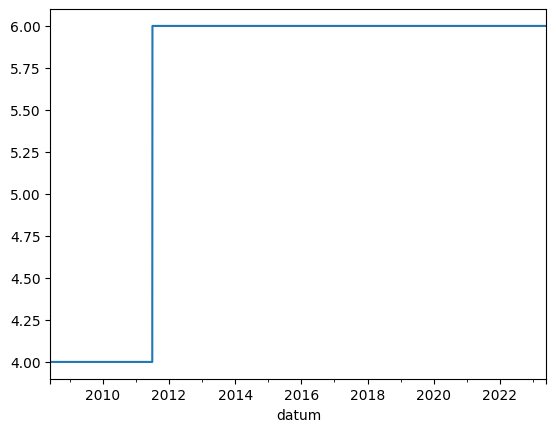

In [13]:
df_daily_data.groupby(df_daily_data.index)['zaehlstelle'].count().plot()

### Conclusion for daily data

After correcting the date format and parsing the date, we can see that the data is fine (one entry for every station on all days) and also our explicit check did not bring up any missing data.

**Daily data is fine without any further modifications**

In [16]:
df_daily_data = df_daily_data.sort_index()
df_daily_data.reset_index(names='datum', inplace=True)

filename = f'cleaned/bicycle-counting-station-daily.json'
df_daily_data.to_json(filename, orient='records', lines=True)